In [163]:
#import libraries
import pandas as pd
import numpy as np
import eli5
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from numpy import mean
from sklearn.model_selection import  StratifiedKFold,RandomizedSearchCV, KFold,cross_validate
from sklearn.metrics import roc_curve, auc,roc_auc_score,classification_report,accuracy_score,f1_score
from eli5.sklearn import PermutationImportance
from IPython.display import display
from scipy import stats
from xgboost import XGBClassifier
from sklearn.cluster import KMeans

In [4]:
#read data
data=pd.read_csv('data.csv')

## Data Analysis

In [5]:
data.head(15)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,no


In [6]:
print(data.shape)
print(data[data.columns].isnull().sum())

(40000, 14)
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64


In [7]:
#print unique values of columns that types' is object
def show_column_unique(columns):
    for column in columns:
        print('Unique values that column '+column+' has:')
        print(data[column].unique())

In [8]:
show_column_unique(data.select_dtypes(['object']).columns)

Unique values that column job has:
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
Unique values that column marital has:
['married' 'single' 'divorced']
Unique values that column education has:
['tertiary' 'secondary' 'unknown' 'primary']
Unique values that column default has:
['no' 'yes']
Unique values that column housing has:
['yes' 'no']
Unique values that column loan has:
['no' 'yes']
Unique values that column contact has:
['unknown' 'cellular' 'telephone']
Unique values that column month has:
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr']
Unique values that column y has:
['no' 'yes']


In [9]:
#Our dataset is imbalanced, we will solve this negative effect with scale_pos_weight that is one of the XGBClassifier parameters
count_no_sub = len(data[data['y']=='no'])
count_sub = len(data[data['y']=='yes'])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("number of no subscription is",count_no_sub,",percentage of no subscription is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("number of no subscription is",count_sub,",percentage of subscription", pct_of_sub*100)

number of no subscription is 37104 ,percentage of no subscription is 92.75999999999999
number of no subscription is 2896 ,percentage of subscription 7.24


## Data visualization
Class of UnderstandingData help us to understand relationship between value of feature and value of y

In [131]:
class UnderstandingData:
    
    def __init__(self, raw_df):
        self.raw_df = raw_df
        self.raw_df_grouped = raw_df.groupby("y")
        self.class_name_no = 'no'
        self.class_name_yes = 'yes'
        self.raw_df_grouped_no = self.raw_df_grouped.get_group(self.class_name_no)
        self.raw_df_grouped_yes = self.raw_df_grouped.get_group(self.class_name_yes)

    def plot_histogram_continuous(self, feature_name, bin_size):
        plt.figure()
        plt.hist(self.raw_df_grouped_no[feature_name], bins=bin_size, label=self.class_name_no)
        plt.hist(self.raw_df_grouped_yes[feature_name], bins=bin_size, label=self.class_name_yes)
        plt.legend()
        plt.title("Feature Histogram - "+feature_name)
        plt.xlabel("Feature values")
        plt.ylabel("Count")

    def plot_histogram_categorical(self, feature_name):
        feature_df = pd.DataFrame()
        feature_df["no"] = self.raw_df_grouped_no[feature_name].value_counts()
        feature_df["yes"] = self.raw_df_grouped_yes[feature_name].value_counts()
        
        feature_df.plot(kind='bar')
        plt.title("Feature Histogram - "+feature_name)
        plt.ylabel("Count")
        plt.xlabel("Feature unique values")
        plt.tight_layout()

###### It seems obvious that as the duration increases, the ratio y = 1 increases.

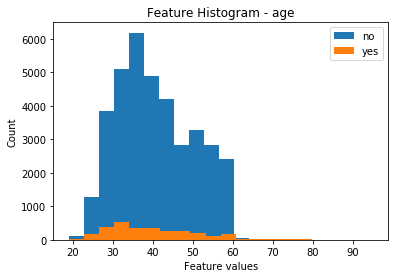

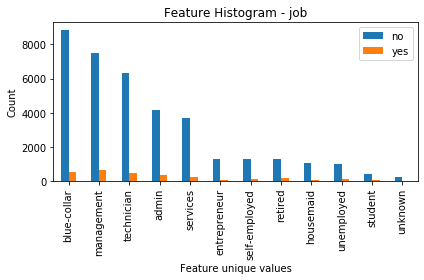

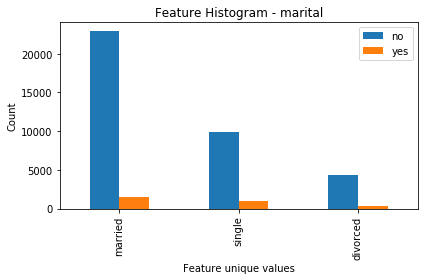

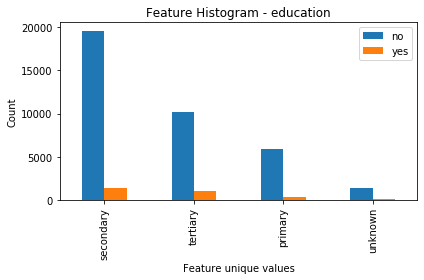

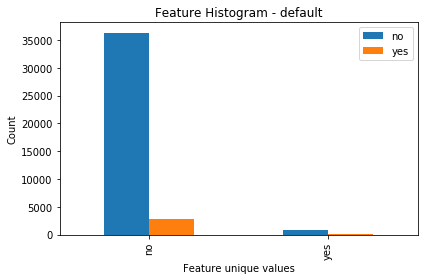

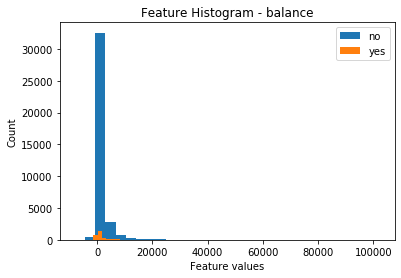

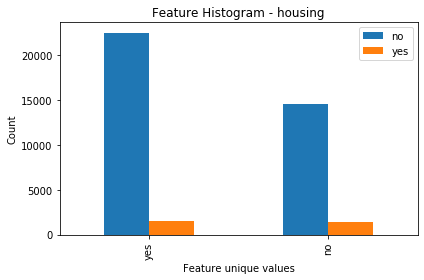

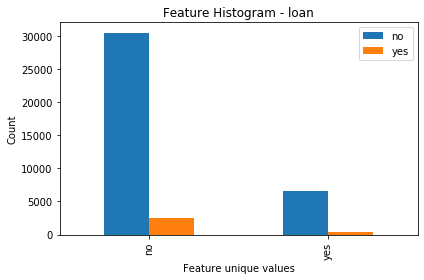

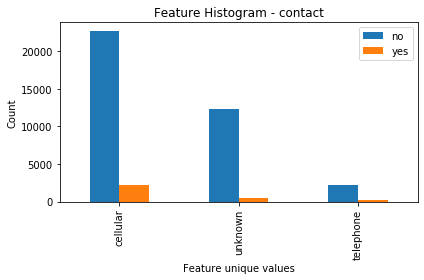

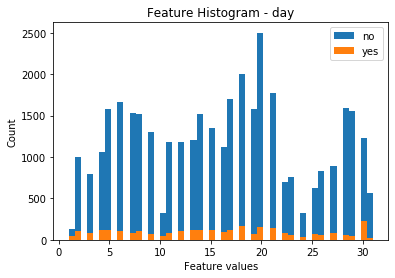

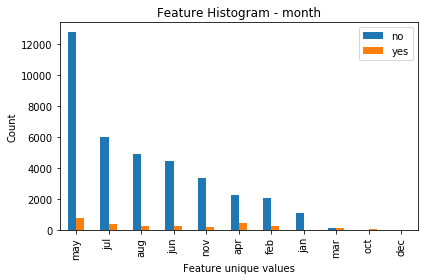

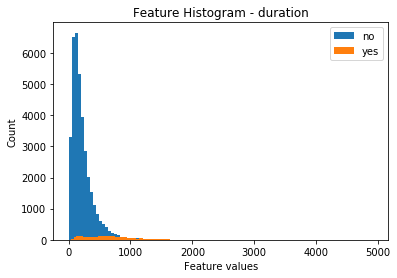

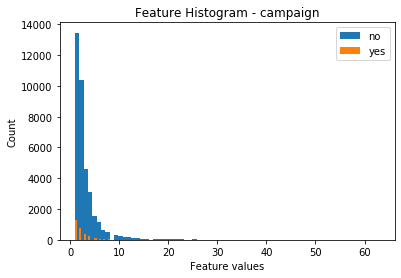

In [101]:
understanding_data = UnderstandingData(data)
understanding_data.plot_histogram_continuous("age",20)
understanding_data.plot_histogram_categorical("job")
understanding_data.plot_histogram_categorical("marital")
understanding_data.plot_histogram_categorical("education")
understanding_data.plot_histogram_categorical("default")
understanding_data.plot_histogram_continuous("balance",30)
understanding_data.plot_histogram_categorical("housing")
understanding_data.plot_histogram_categorical("loan")
understanding_data.plot_histogram_categorical("contact")
understanding_data.plot_histogram_continuous("day",50)
understanding_data.plot_histogram_categorical("month")
understanding_data.plot_histogram_continuous("duration",100)
understanding_data.plot_histogram_continuous("campaign",70)

## Change features type from object to numerical value for model analysis

In [10]:
#one-hot encoding for categorical features
df = data.copy()
cols_cat=['job','marital','education','contact','month']

df=pd.concat([df,pd.get_dummies(df[cols_cat], drop_first=False)],axis=1)
df=df.drop(cols_cat,axis=1)
df.head()

,age,default,balance,housing,loan,day,duration,campaign,y,job_admin,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,no,2143,yes,no,5,261,1,no,0,...,0,0,0,0,0,0,0,1,0,0
1,44,no,29,yes,no,5,151,1,no,0,...,0,0,0,0,0,0,0,1,0,0
2,33,no,2,yes,yes,5,76,1,no,0,...,0,0,0,0,0,0,0,1,0,0
3,47,no,1506,yes,no,5,92,1,no,0,...,0,0,0,0,0,0,0,1,0,0
4,33,no,1,no,no,5,198,1,no,0,...,0,0,0,0,0,0,0,1,0,0


In [11]:
#convert binary features to numeric binary features
replace_map_default = {'default': {'no': 0, 'yes': 1}}
replace_map_housing = {'housing': {'no': 0, 'yes': 1}}
replace_map_loan = {'loan': {'no': 0, 'yes': 1}}
replace_map_y = {'y': {'no': 0, 'yes': 1}}

df.replace(replace_map_default, inplace=True)
df.replace(replace_map_housing, inplace=True)
df.replace(replace_map_loan, inplace=True)
df.replace(replace_map_y, inplace=True)

## Normalization for better model performance

In [12]:
#normalization
scaler = MinMaxScaler() 
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

In [13]:
X = df_scaled.loc[:, df_scaled.columns != 'y']
y = df_scaled.loc[:, df_scaled.columns == 'y']

# Hyperparameter Search
We aims to achieve best parameters for XGBClassifier.While we do it. We work with 5-fold validation to create 5 best parameter.<br>
Due to this code may take up to 1 hour to run. There is one of the best parameter that achieved at next line. We use this to achieve quickly to result.

In [9]:


clf_xgb = XGBClassifier(objective = 'binary:logistic',scale_pos_weight=5)
param_dist = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }
clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 25, scoring = 'f1', error_score = 0, verbose = 3, n_jobs = -1)

numFolds = 5
folds = KFold(n_splits = numFolds, shuffle = True)

estimators = []
results = np.zeros(len(X))
score = 0.0
for train_index, test_index in folds.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    clf.fit(X_train, y_train)

    estimators.append(clf.best_estimator_)
    results[test_index] = clf.predict(X_test)
    score += f1_score(y_test, results[test_index])
score /= numFolds

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 15.3min finished


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 15.9min finished


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 13.2min finished


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  7.5min finished


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  8.5min finished


In [15]:
print(estimators)

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5879779861572796, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.012272445304314906, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=389, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5,
              subsample=0.8209599087353141, tree_method='exact',
              validate_parameters=1, verbosity=None), XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6593628607237711, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.016614716649697693, max_delta_step=0, max_depth=4,
              min_child_weight=3, missing=nan, monot

## In order to be fast, we take one of the best parameter and set up new XGBClassifier

<ul list-style-type: square>
  <li><b>compute_metrics():</b> Compute precision, recall, f1-score, accuracy, roc-auc vb. metrics for every test part in k-fold validation.</li>
  <li><b>evaluate_feature_importance():</b> Evaluate all of the features and display by importances of features.</li>
  <li>We achieve approximately 0.90 accuracy.</li>
   <li>Duration parameter seem to most of strong feature to affect result.</li>
</ul>

In [14]:
def compute_metrics(i):
    y_predict = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_predict)
    auc_score = roc_auc_score(y_test, y_predict)
    print("Result of metrics for the Fold "+str(i+1))
    print("Accuracy", accuracy_score(y_test, y_predict.round()))
    print(classification_report(y_test, y_predict.round(), labels=[0,1]))
    plt.plot(fpr,tpr,label="Fold "+str(i+1)+ " auc="+str(auc_score))
    plt.legend(loc=4)
    plt.show()
    


In [15]:
def evaluate_feature_importance(i):
    print("List sorted by importance of features for the Fold "+str(i+1))
    perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
    display(eli5.show_weights(perm, top=50, feature_names = X.columns.tolist()))

Result of metrics for the Fold 1
Accuracy 0.896875
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      7434
           1       0.38      0.73      0.50       566

    accuracy                           0.90      8000
   macro avg       0.68      0.82      0.72      8000
weighted avg       0.94      0.90      0.91      8000



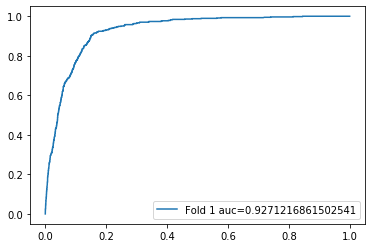

List sorted by importance of features for the Fold 1


Weight,Feature
0.0720 ± 0.0035,duration
0.0078 ± 0.0028,contact_unknown
0.0058 ± 0.0024,housing
0.0034 ± 0.0008,month_jun
0.0032 ± 0.0010,month_apr
0.0024 ± 0.0003,month_mar
0.0012 ± 0.0004,month_oct
0.0006 ± 0.0008,month_jul
0.0006 ± 0.0010,month_nov
0.0003 ± 0.0003,month_feb


Result of metrics for the Fold 2
Accuracy 0.906625
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      7389
           1       0.43      0.73      0.54       611

    accuracy                           0.91      8000
   macro avg       0.70      0.82      0.75      8000
weighted avg       0.93      0.91      0.92      8000



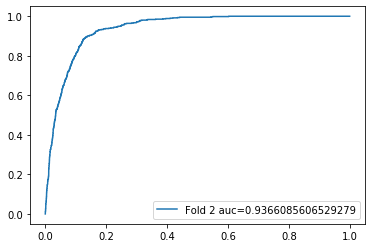

List sorted by importance of features for the Fold 2


Weight,Feature
0.0774 ± 0.0022,duration
0.0071 ± 0.0018,month_jun
0.0068 ± 0.0012,contact_unknown
0.0038 ± 0.0012,housing
0.0029 ± 0.0011,month_apr
0.0025 ± 0.0011,month_mar
0.0011 ± 0.0005,month_oct
0.0008 ± 0.0010,day
0.0008 ± 0.0004,month_feb
0.0005 ± 0.0005,month_nov


Result of metrics for the Fold 3
Accuracy 0.90925
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      7436
           1       0.42      0.76      0.54       564

    accuracy                           0.91      8000
   macro avg       0.70      0.84      0.75      8000
weighted avg       0.94      0.91      0.92      8000



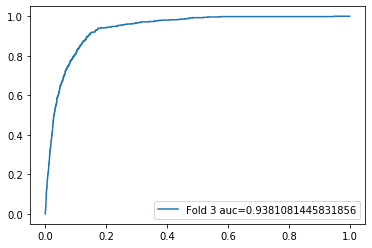

List sorted by importance of features for the Fold 3


Weight,Feature
0.0781 ± 0.0029,duration
0.0072 ± 0.0023,contact_unknown
0.0044 ± 0.0023,month_jun
0.0034 ± 0.0010,housing
0.0034 ± 0.0010,month_mar
0.0024 ± 0.0014,month_apr
0.0013 ± 0.0006,month_jul
0.0010 ± 0.0005,month_feb
0.0008 ± 0.0005,day
0.0007 ± 0.0003,balance


Result of metrics for the Fold 4
Accuracy 0.907
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      7401
           1       0.43      0.71      0.53       599

    accuracy                           0.91      8000
   macro avg       0.70      0.82      0.74      8000
weighted avg       0.93      0.91      0.92      8000



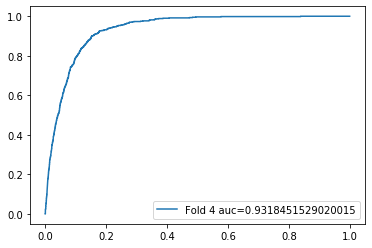

List sorted by importance of features for the Fold 4


Weight,Feature
0.0745 ± 0.0047,duration
0.0113 ± 0.0024,contact_unknown
0.0050 ± 0.0021,month_jun
0.0040 ± 0.0005,month_mar
0.0036 ± 0.0013,housing
0.0016 ± 0.0016,month_apr
0.0014 ± 0.0004,day
0.0012 ± 0.0004,month_jan
0.0008 ± 0.0009,month_nov
0.0008 ± 0.0004,month_oct


Result of metrics for the Fold 5
Accuracy 0.903625
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      7444
           1       0.40      0.76      0.52       556

    accuracy                           0.90      8000
   macro avg       0.69      0.84      0.73      8000
weighted avg       0.94      0.90      0.92      8000



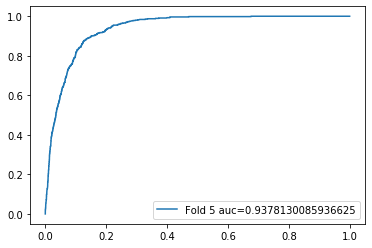

List sorted by importance of features for the Fold 5


Weight,Feature
0.0754 ± 0.0016,duration
0.0069 ± 0.0015,contact_unknown
0.0049 ± 0.0023,month_jun
0.0042 ± 0.0013,housing
0.0027 ± 0.0008,month_mar
0.0020 ± 0.0009,month_apr
0.0013 ± 0.0010,day
0.0008 ± 0.0006,month_jan
0.0006 ± 0.0003,month_nov
0.0006 ± 0.0003,month_oct


In [111]:
model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9238311922903826, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.01629075694354179, max_delta_step=0, max_depth=3,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=254, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5,
              subsample=0.8420605586117003, tree_method='exact',
              validate_parameters=1, verbosity=None)

numFolds = 5
folds = KFold(n_splits = numFolds, shuffle = True)
#y_predicts= np.zeros(len(X))
y_predicts = pd.DataFrame(0, index=np.arange(0, len(X)), columns=['y_pred'])
for (train_index, test_index),i in zip(folds.split(X),range(5)):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    model.fit(X_train, y_train)
    
    compute_metrics(i)
    evaluate_feature_importance(i)
    y_predicts.iloc[test_index,:]=np.reshape(model.predict_proba(X_test)[:,1],(-1,1))

# Customer Segmentation


<ul list-style-type: square>
  <li> We use k-means clustring algorithm to segment probability of customers</li>

</ul>

In [181]:
#we split the predictions from 0.5 up and down
y_1=y_predicts[y_predicts['y_pred']>0.5]
y_0=y_predicts[y_predicts['y_pred']<=0.5]


## Segmentation for y>0.5

<ul list-style-type: square>
  <li>We find out that best number of cluster is 4.</li>

</ul>

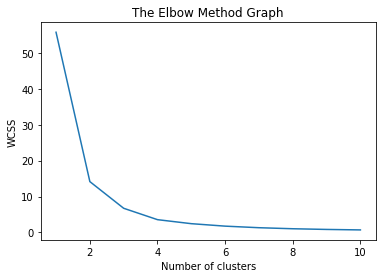

In [182]:
#Using the elbow method to find out the optimal number of clusters. 
wcss_1=[]

for i in range(1,11): 
     kmeans_1 = KMeans(n_clusters=i, init ='k-means++', max_iter=300,tol=1e-04, n_init=10,random_state=0 ) 
     kmeans_1.fit(y_1)
     wcss_1.append(kmeans_1.inertia_)
#kmeans inertia_ attribute is:  Sum of squared distances of samples #to their closest cluster center.
#Plot the elbow graph
plt.plot((range(1,11)),wcss_1)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [222]:
#Apply k-means for clustering
n_clusters=4
km = KMeans(
    n_clusters=n_clusters, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = pd.DataFrame(0, index=y_1.index, columns=['y_km'])
y_km['y_km'] =np.reshape(km.fit_predict(y_1),(-1,1)) 

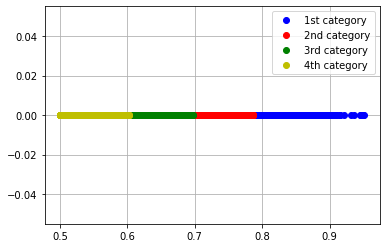

In [239]:
#plot customer segmentation graph
plt.plot(y_1[y_km['y_km']==1],np.zeros_like(y_1[y_km['y_km']==1]), 'bo')
plt.plot(y_1[y_km['y_km']==2],np.zeros_like(y_1[y_km['y_km']==2]), 'ro')
plt.plot(y_1[y_km['y_km']==0],np.zeros_like(y_1[y_km['y_km']==0]), 'go')
plt.plot(y_1[y_km['y_km']==3],np.zeros_like(y_1[y_km['y_km']==3]), 'yo')
plt.gca().legend(('1st category','2nd category','3rd category','4th category'))
plt.grid()
plt.show()

In [224]:
#İndicate indexes of costumer from most high probability to less probability
print("Indexes of customers in the 1st category(most high probability to buy):",y_km[y_km['y_km']==1].index.values)
print("Indexes of customers in the 2nd category",y_km[y_km['y_km']==2].index.values)
print("Indexes of customers in the 3rd category",y_km[y_km['y_km']==0].index.values)
print("Indexes of customers in the 4th category",y_km[y_km['y_km']==3].index.values)

Indexes of customers in the 1st category(most high probability to buy): [   59    87   109 ... 39979 39988 39991]
Indexes of customers in the 2nd category [   37    43    53 ... 39879 39921 39994]
Indexes of customers in the 3rd category [  130   168   179 ... 39901 39961 39978]
Indexes of customers in the 4th category [   38    44   151 ... 39990 39996 39998]


## Segmentation for y<=0.5

<ul list-style-type: square>
  <li>We find out that best number of cluster is 4.</li>

</ul>

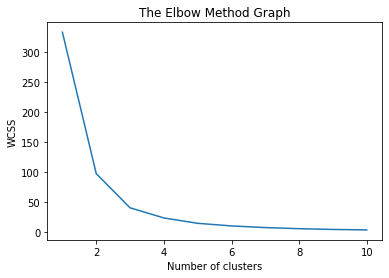

In [171]:
#Using the elbow method to find out the optimal number of clusters. 
wcss=[]

for i in range(1,11): 
     kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,tol=1e-04, n_init=10,random_state=0 ) 
     kmeans.fit(y_0)
     wcss.append(kmeans.inertia_)
#kmeans inertia_ attribute is:  Sum of squared distances of samples #to their closest cluster center.
#Plot the elbow graph
plt.plot((range(1,11)),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [247]:
#Apply k-means for clustering
n_clusters=4
km = KMeans(
    n_clusters=n_clusters, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = pd.DataFrame(0, index=y_0.index, columns=['y_km'])
y_km['y_km'] =np.reshape(km.fit_predict(y_0),(-1,1)) 


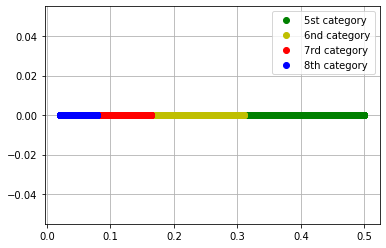

In [249]:
#plot customer segmentation graph
plt.plot(y_0[y_km['y_km']==0],np.zeros_like(y_0[y_km['y_km']==0]), 'go')
plt.plot(y_0[y_km['y_km']==3],np.zeros_like(y_0[y_km['y_km']==3]), 'yo')
plt.plot(y_0[y_km['y_km']==2],np.zeros_like(y_0[y_km['y_km']==2]), 'ro')
plt.plot(y_0[y_km['y_km']==1],np.zeros_like(y_0[y_km['y_km']==1]), 'bo')


plt.gca().legend(('5st category','6nd category','7rd category','8th category'))
plt.grid()
plt.show()

In [251]:
#İndicate indexes of costumer from most high probability to less probability
print("Indexes of customers in the 5st category:",y_km[y_km['y_km']==0].index.values)
print("Indexes of customers in the 6nd category",y_km[y_km['y_km']==3].index.values)
print("Indexes of customers in the 7rd category",y_km[y_km['y_km']==2].index.values)
print("Indexes of customers in the 8th category(most low probability to buy)",y_km[y_km['y_km']==1].index.values)

Indexes of customers in the 5st category: [   12    66    85 ... 39982 39986 39992]
Indexes of customers in the 6nd category [  178   202   204 ... 39984 39993 39997]
Indexes of customers in the 7rd category [    7    30    36 ... 39989 39995 39999]
Indexes of customers in the 8th category(most low probability to buy) [    0     1     2 ... 39941 39950 39983]
